# Constantes y Logger

In [1]:
# %cd ~/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters

In [2]:
SAVE_FIGS = True  # If you want to save the figures.
RUN_MCMC = True  # If you want to run the MCMC's algorithms or use saved chains

BURN = 2_000
NUM_SAMPLES = 50_000
N_WALKERS = 8



BURN = 100
NUM_SAMPLES = 1_000
N_WALKERS = 2

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
import time

import bwb.utils.plotters as plotters
from bwb.distributions.posterior_samplers import NUTSPosteriorSampler

In [4]:
import torch
import numpy as np
import random

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

torch.backends.cudnn.deterministic = True

In [5]:
from bwb import logging_ as logging

log = logging.get_logger(__name__)

In [6]:
from pathlib import Path

CURR_PATH = Path().absolute()
print(f"{CURR_PATH = }")
BASE_PATH = CURR_PATH.parent.parent
print(f"{BASE_PATH = }")
DATA_PATH = BASE_PATH / "data"
print(f"{DATA_PATH = }")
NETS_PATH = BASE_PATH / "wgan_gp" / "networks" 
print(f"{NETS_PATH = }")
IMGS_PATH = CURR_PATH / "imgs" / "notebook-03-new"
IMGS_PATH.mkdir(parents=True, exist_ok=True)
print(f"{IMGS_PATH = }")
MCMC_PATH = BASE_PATH / "saved_mcmc"
print(f"{MCMC_PATH = }")
NUTS_PATH = MCMC_PATH / "NUTS"
print(f"{NUTS_PATH = }")

CURR_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/examples/02-distribution-sampler')
BASE_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters')
DATA_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/data')
NETS_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/wgan_gp/networks')
IMGS_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/examples/02-distribution-sampler/imgs/notebook-03-new')
MCMC_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/saved_mcmc')
NUTS_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/saved_mcmc/NUTS')


In [7]:
from bwb.config import conf

conf.use_single_precision()
conf.set_eps(1e-20)
conf

Config(dtype=torch.float32, device=cuda:0, eps=1.00e-20)

# Sampleador de Distribuciones Posterior

Al igual que los muestreadores de distribuciones anteriores, los muestreadores a posteriori heredan de `bwb.distributions.distribution_samplers.DistributionSampler`. En este caso, tenemos a la clase abstracta
`bwb.distributions.posterior_samplers.BaseLatentMCMCPosteriorSampler` que define un MCMC utilizando la librería `hamiltorch`.

Al igual que en `bwb.distributions.distribution_samplers.GeneratorDistribSampler`, la forma de ajustar esta clase es con un generador `generator`, una transformación `transform_out`, un muestreador de ruido `noise_sampler` y datos para la posterior `data`.

## Obtener el modelo para muestrear los datos

Definimos el Dataset para obtener la primera cara y poder muestrear de ella


torch.Size([32, 32])


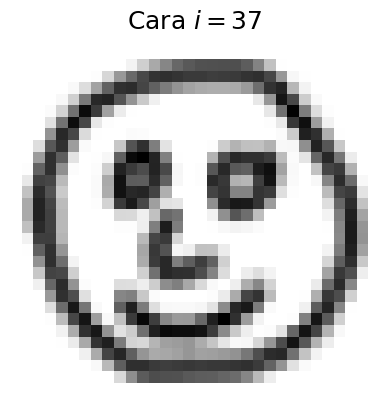

In [8]:
from quick_torch import QuickDraw
import torchvision.transforms.v2 as T
from pathlib import Path

transforms = T.Compose([
    T.ToImage(),
    T.Resize(32),
    T.ToDtype(torch.float32, scale=True),
    T.Lambda(lambda x: x.squeeze()),
])

ds = QuickDraw(
    DATA_PATH,
    categories="face",
    download=True,
    transform=transforms,
)

# You can use the wrapper to transform the usual DataSet into a model set
from bwb.distributions.models import ModelDataset

ds = ModelDataset(ds)

from bwb.distributions.distribution_samplers import UniformDiscreteSampler
ds_sampler = UniformDiscreteSampler().fit(ds)

i = 37
first_face = ds.get(i)
print(first_face.shape)
_ = plotters.plot_draw(first_face, title=f"Cara $i={i}$")

Obtenemos una muestra y lo graficamos en un histograma

## Obtener data

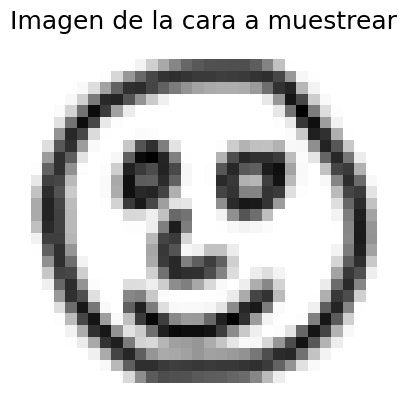

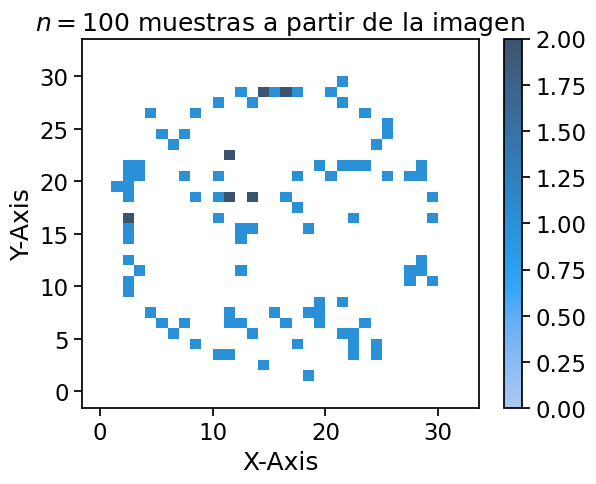

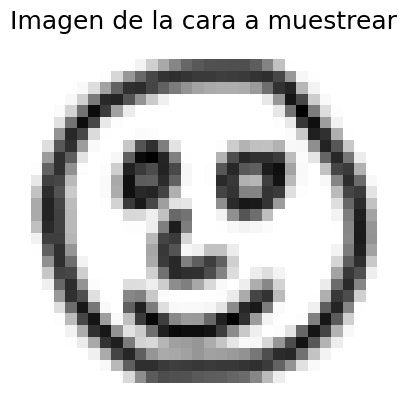

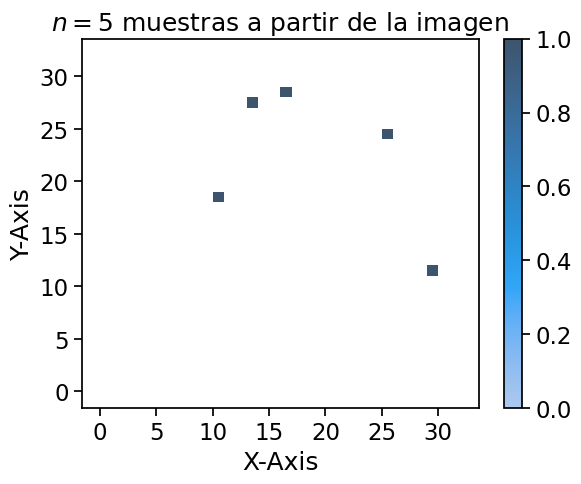

In [9]:
def plot_img_hist(face, data, n_data=None, plot=True, exp=None,
                  title="Imagen de la cara a muestrear",
                  hist_title="$n={}$ muestras a partir de la imagen",
                  ):
    data_ = data.clone()
    if n_data is None:
        n_data = len(data)
    else:
        data = data[:n_data]

    shape = face.shape
    data_coords = face.enumerate_support_()[data].cpu().numpy() + np.random.randn(n_data, 2) * 0.1

    if plot:
        fig_ax1 = plotters.plot_draw(face, title=title)
        ax2 = plotters.plot_histogram_from_points(data_coords, 
                                                  title=hist_title.format(n_data),
                                                  rotate=True,
                                                  shape=shape,
                                                  histplot_kwargs=dict(bins=shape[0])
                                                 )

    return face, data_, fig_ax1, ax2

def get_data(face, n_data, plot=True, exp=None,
             title="Imagen de la cara a muestrear",
             hist_title="$n={}$ muestras a partir de la imagen",
            ):
    data = face.sample((n_data,))

    return plot_img_hist(face, data, n_data, plot, exp, title, hist_title)


def get_sampler(sampler, n_data, plot=True, exp=None,
                title="Face sampled from dataset",
                hist_title="Histogram of the distribution generated by a drawing",
               ):
    return get_data(sampler.draw(), n_data, plot, exp, title, hist_title)



# _, _, (fig1, ax1), (fig2, ax2) = get_sampler(ds_sampler, 100)
_, data, (fig1, ax1), (fig2, ax2) = get_data(first_face, 100)
_ = plot_img_hist(first_face, data, 5)

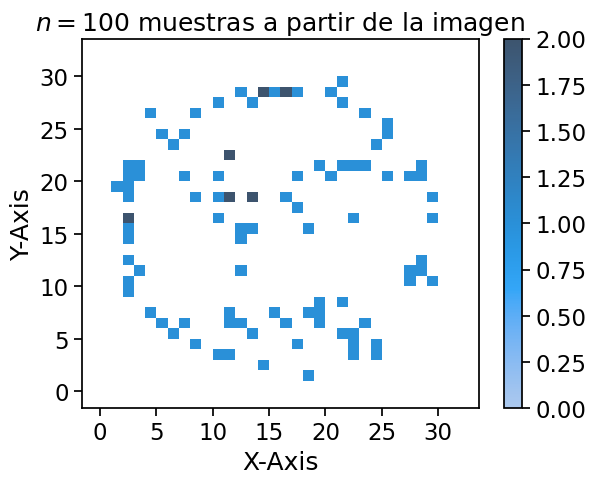

In [10]:
fig2

## Definir red neuronal generadora y transformador

Se define la red neuronal de la misma manera que en el notebook anterior

In [11]:
from wgan_gp.wgan_gp_vae.model_resnet import Generator, Encoder, LatentDistribution
import torch
from wgan_gp.wgan_gp_vae.utils import load_checkpoint


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NOISE = "norm"
LATENT_DIM = 128
CHANNELS_IMG = 1
NUM_FILTERS = [256, 128, 64, 32]

noise_sampler = LatentDistribution(NOISE, LATENT_DIM, device)

G = Generator(LATENT_DIM, CHANNELS_IMG, latent_distr=NOISE).to(device)
E = Encoder(LATENT_DIM, CHANNELS_IMG).to(device)

DS_NAME = "data"
FACE_PATH = NETS_PATH / f"cleaned_{DS_NAME}_zDim{LATENT_DIM}_{NOISE}_bs_128"

load_checkpoint(G, FACE_PATH, "generator", device)
load_checkpoint(E, FACE_PATH, "encoder", device)

G.eval(); E.eval()
print()

In [12]:
from bwb.distributions import DistributionDraw
from torchvision import disable_beta_transforms_warning
disable_beta_transforms_warning()

import torchvision.transforms.v2 as T


z = noise_sampler(1)
m = G(z)

transform_in = T.Compose([
    T.Lambda(lambda x: x / torch.max(x)),
    T.ToPILImage(),
    T.Resize(32),
    T.ToImage(),
    T.ConvertImageDtype(torch.float32),
    T.Normalize((0.5,), (0.5,)),
])

transform_out_ = T.Compose([
    T.ToDtype(torch.float64),
    T.Lambda(lambda x: x.squeeze()),
    T.Lambda(lambda x: x - torch.min(x)),
    T.Lambda(lambda x: x / torch.sum(x)),
])

transform_out = T.Compose([
    transform_out_,
    T.Lambda(lambda x: DistributionDraw.from_grayscale_weights(x)),
])

# Experimentos

### Experimentos con una cara fija, n variable

#### n = 5

In [13]:
nuts_params = dict(
    n_walkers=N_WALKERS,
    num_steps_per_sample=1,
    # burn=BURN,
    desired_accept_rate=0.6,
)
nuts_params.get("burn", None)

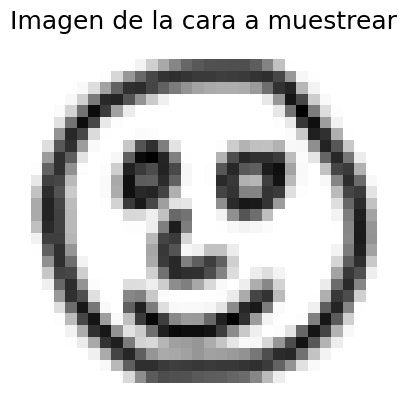

torch.Size([5])
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Final Adapted Step Size:  0.2063668817281723---- |   90/1100 | 70.69       
0d:00:00:16 | 0d:00:00:00 | #################### | 1100/1100 | 64.77       
Acceptance Rate 0.65
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Final Adapted Step Size:  0.29130682349205017--- |   91/1100 | 59.52       


2024-07-09 10:01:58,352: WARNING [bwb.distributions.distribution_samplers:579]
> The generator_, transform_out_ and noise_sampler_ attributes will not be saved. Use fit method to fit these attributes.
/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/bwb/logging_.py:673: RuntimeWarning: The generator_, transform_out_ and noise_sampler_ attributes will not be saved. Use fit method to fit these attributes.
  log_config.raise_warning(msg, logger, warning_category, stacklevel, level,
2024-07-09 10:01:58,354: WARNING [bwb.distributions.distribution_samplers:579]
> The samples will be saved in half precision. To disable this behavior, set the attribute SAVE_HALF_PRECISION to False.



Acceptance Rate 0.54


/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/bwb/logging_.py:673: RuntimeWarning: The samples will be saved in half precision. To disable this behavior, set the attribute SAVE_HALF_PRECISION to False.
  log_config.raise_warning(msg, logger, warning_category, stacklevel, level,
ic| toc - tic: 0.4327842800412327
2024-07-09 10:01:59,207: WARNING [bwb.utils.autocorr:149]
> The chain is shorter than 50 times the integrated autocorrelation time for 128 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: tensor([ 50.5548,  73.6488,  66.4520,  28.7361,  72.1703,  29.1523,  66.1420,
         35.2660,  54.6972,  84.7402,  78.4609, 109.1856,  38.2929,  86.6669,
         56.4317,  32.8564,  35.4485,  66.6112,  71.9679,  37.8070,  68.6635,
         39.2131,  32.7804, 100.7256,  75.5298,  44.3034,  58.9575,  39.0107,
         34.0760,  30.7490,  39.9622,  49.2867,  34.1670,  22.5840,  72.9790,
         77.3444,  60.2936,  61

54


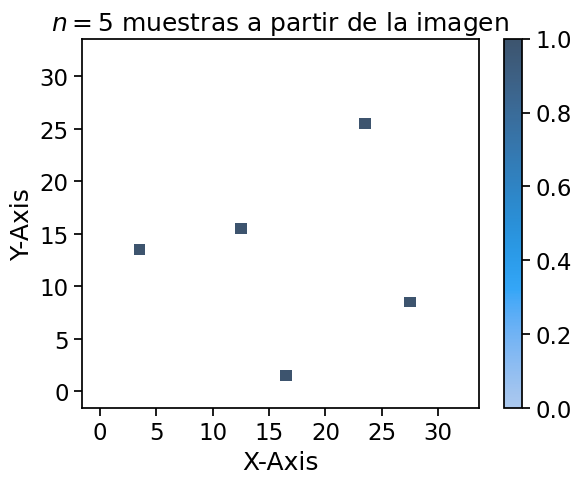

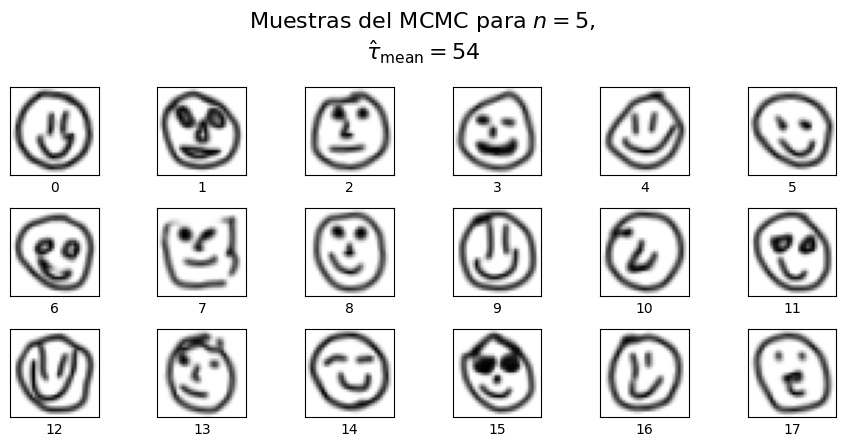

Images saved with name image-sampler-n-5
Images saved with name samples-hist-n-5


In [14]:
N = 5

NUTS_PARAMS = dict(
    n_walkers=N_WALKERS,
    num_steps_per_sample=1,
    burn=BURN,
    desired_accept_rate=0.6,
)

RUN_PARAMS = dict(
    n_steps=NUM_SAMPLES
)

MCMC_PLOT_PARAMS = dict(
    n_rows=3, n_cols=6,
)

def save_fig(fig, name_to_save: str, imgs_path=IMGS_PATH):
    path_to_save = imgs_path / name_to_save
    fig.savefig(path_to_save.with_suffix(".pdf"), bbox_inches="tight")
    fig.savefig(path_to_save.with_suffix(".png"), bbox_inches="tight")
    print("Images saved with name", name_to_save)

def run_mcmc_experiment(
    face,
    data,
    n_data,
    thin=None,
    nuts_params=NUTS_PARAMS,
    run_params=RUN_PARAMS,
    mcmc_plot_params=MCMC_PLOT_PARAMS,
    run_mcmc=RUN_MCMC,
    mcmc_path=NUTS_PATH,
):
    # Constants
    burn = nuts_params.get("burn", None)
    num_samples = run_params.get("n_steps", None)
    n_walkers = nuts_params.get("n_walkers", None)
    n_rows = mcmc_plot_params.get("n_rows", 6)
    n_cols = mcmc_plot_params.get("n_cols", 12)
    
    # Path to save the chain
    mcmc_2_save_path = mcmc_path / (f"n-{n_data}-"
                                    f"burn-{burn:_}-"
                                    f"num_samples-{num_samples:_}-" 
                                    f"n_walkers-{n_walkers}")
    mcmc_2_save_path = mcmc_2_save_path.with_suffix(".pkl.gz")

    # Getting the data
    data = data.clone()[:n_data]
    face, data, (fig1, _), (hist1, _) = plot_img_hist(face, data, n_data)
    print(data.shape)

    # Train the MCMC, or load if there are one in the cache
    if not mcmc_2_save_path.exists() or run_mcmc:
        post_pi_n = NUTSPosteriorSampler(**nuts_params).fit(
            G, transform_out_, noise_sampler, data,
        )
        
        post_pi_n.run(**run_params)
    
        tic = time.perf_counter()
        post_pi_n.save(mcmc_2_save_path)
        toc = time.perf_counter()
        ic(toc - tic)
        
    else:
        post_pi_n = NUTSPosteriorSampler.load(mcmc_2_save_path)
        post_pi_n.fit(G, transform_out_, noise_sampler, data)

    # Computing the mean autocorr time
    mean_autocorr_time = int(post_pi_n.get_autocorr_time().mean())
    print(mean_autocorr_time)

    title = ("Muestras del MCMC para " 
             + r"$n = " + f"{n_data}$, \n"
             + r"$\hat\tau_\mathrm{mean}" 
             + f"={mean_autocorr_time}$")
    mcmc_plot_params.update({"title": title})

    post_pi_n.shuffle_samples_cache(thin=thin or int(mean_autocorr_time))

    # Plot some samples form the posterior
    max_imgs = n_rows * n_cols
    fig2, ax = plotters.plot_list_of_draws(
        post_pi_n.sample(max_imgs),
        **mcmc_plot_params
    )

    return post_pi_n, (fig1, hist1, fig2)


data = first_face.sample((1_000,))

post_pi_n, (fig1, hist1, fig2) = run_mcmc_experiment(first_face, data, N)

if SAVE_FIGS:
    save_fig(fig1, f"image-sampler-n-{N}")
    save_fig(hist1, f"samples-hist-n-{N}")

In [15]:
POST_DATA_PATH = CURR_PATH / "data"  # / f"n_data-{N_DATA}.pkl"
POST_DATA_PATH.mkdir(parents=True, exist_ok=True)
DATA_PATH_ = POST_DATA_PATH / f"data-{i}.pkl"
print(DATA_PATH_)

/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/examples/02-distribution-sampler/data/data-37.pkl


ic| not DATA_PATH_.exists(): False


Ejecutando la cadena con n = 5


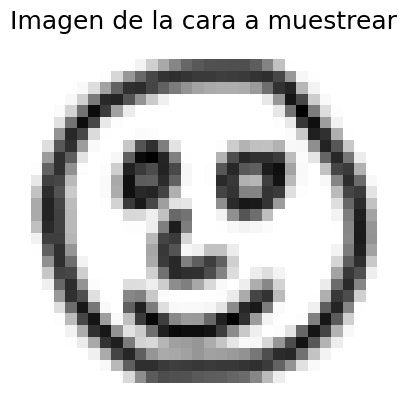

torch.Size([5])
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples       | Samples/sec
Final Adapted Step Size:  0.19725951552391052--- |   1990/152000 | 52.22       
0d:00:42:28 | 0d:00:00:00 | #################### | 152000/152000 | 59.65       
Acceptance Rate 0.67
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples       | Samples/sec
Final Adapted Step Size:  0.23383793234825134--- |   1988/152000 | 62.98       
0d:00:39:11 | 0d:00:00:00 | #################### | 152000/152000 | 64.64       
Acceptance Rate 0.62
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples       | Samples/sec
Final Adapted Step Size:  0.2336358278989792---- |   1989/152000 | 61.01       
0d:00:39:56 | 0d:00:00:00 | #################### | 152000/152000 | 63.44       
Acceptance Rate 0.63
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| 

2024-07-09 15:49:41,793: WARNING [bwb.distributions.distribution_samplers:579]
> The generator_, transform_out_ and noise_sampler_ attributes will not be saved. Use fit method to fit these attributes.
/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/bwb/logging_.py:673: RuntimeWarning: The generator_, transform_out_ and noise_sampler_ attributes will not be saved. Use fit method to fit these attributes.
  log_config.raise_warning(msg, logger, warning_category, stacklevel, level,
2024-07-09 15:49:41,806: WARNING [bwb.distributions.distribution_samplers:579]
> The samples will be saved in half precision. To disable this behavior, set the attribute SAVE_HALF_PRECISION to False.
/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/bwb/logging_.py:673: RuntimeWarning: The samples will be saved in half precision. To disable this behavior, set the attribute SAVE_HALF_PRECISION to False.
  log_config.raise_warning(msg, l

132


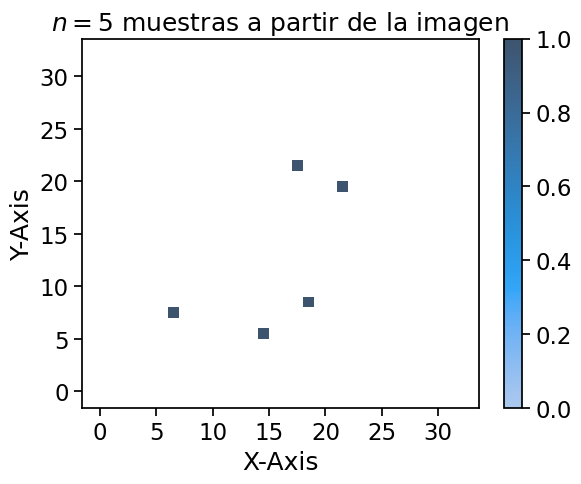

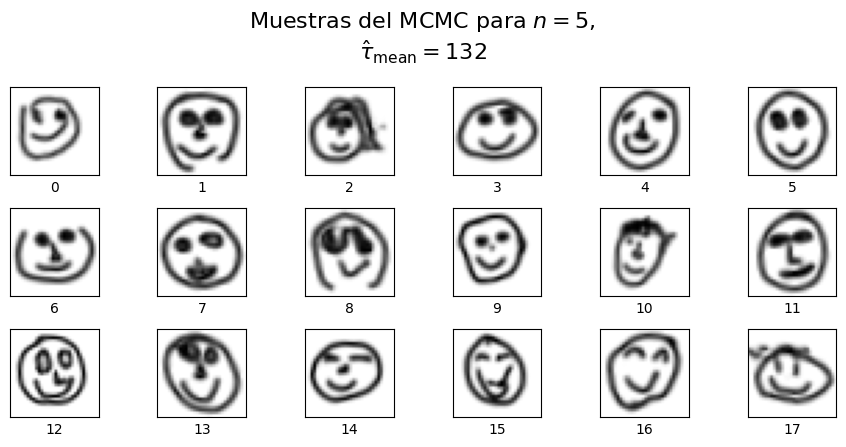

Images saved with name image-sampler-i-37
Images saved with name samples-hist-n-5
Images saved with name mcmc-n-5-NUTSPosteriorSampler
Ejecutando la cadena con n = 20


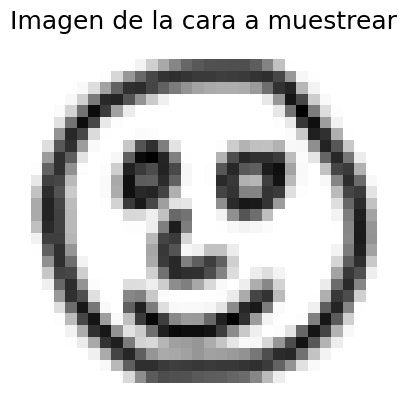

torch.Size([20])
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples       | Samples/sec
Final Adapted Step Size:  0.13670720160007477--- |   1988/152000 | 72.85       
0d:00:45:01 | 0d:00:00:00 | #################### | 152000/152000 | 56.27       
Acceptance Rate 0.59
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples       | Samples/sec
Final Adapted Step Size:  0.13546770811080933--- |   1998/152000 | 47.78       
0d:00:45:53 | 0d:00:00:00 | #################### | 152000/152000 | 55.20       
Acceptance Rate 0.59
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples       | Samples/sec
Final Adapted Step Size:  0.11505391448736191--- |   1986/152000 | 59.32       
0d:00:46:49 | 0d:00:00:00 | #################### | 152000/152000 | 54.10       
Acceptance Rate 0.65
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.|

2024-07-09 21:39:52,836: WARNING [bwb.distributions.distribution_samplers:579]
> The generator_, transform_out_ and noise_sampler_ attributes will not be saved. Use fit method to fit these attributes.
/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/bwb/logging_.py:673: RuntimeWarning: The generator_, transform_out_ and noise_sampler_ attributes will not be saved. Use fit method to fit these attributes.
  log_config.raise_warning(msg, logger, warning_category, stacklevel, level,
2024-07-09 21:39:52,850: WARNING [bwb.distributions.distribution_samplers:579]
> The samples will be saved in half precision. To disable this behavior, set the attribute SAVE_HALF_PRECISION to False.
/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/bwb/logging_.py:673: RuntimeWarning: The samples will be saved in half precision. To disable this behavior, set the attribute SAVE_HALF_PRECISION to False.
  log_config.raise_warning(msg, l

471


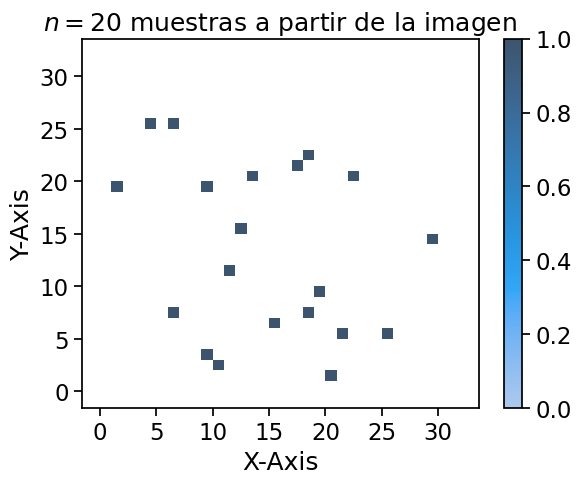

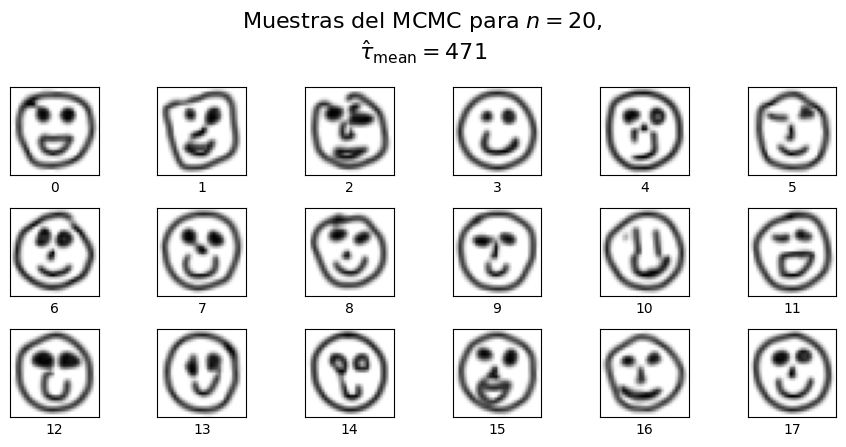

Images saved with name image-sampler-i-37
Images saved with name samples-hist-n-20
Images saved with name mcmc-n-20-NUTSPosteriorSampler
Ejecutando la cadena con n = 50


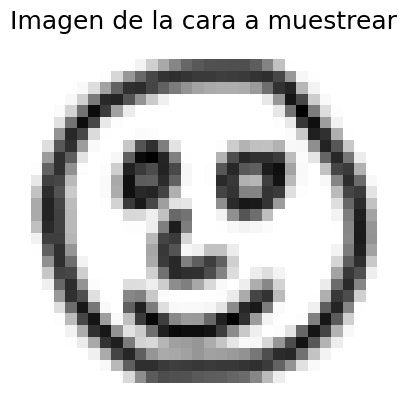

torch.Size([50])
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples       | Samples/sec
Final Adapted Step Size:  0.09369132667779922--- |   1995/152000 | 75.55       
0d:00:43:55 | 0d:00:00:00 | #################### | 152000/152000 | 57.67       
Acceptance Rate 0.58
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples       | Samples/sec
Final Adapted Step Size:  0.0754096508026123---- |   1987/152000 | 59.12       
0d:00:46:28 | 0d:00:00:00 | #################### | 152000/152000 | 54.50       
Acceptance Rate 0.65
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples       | Samples/sec
Final Adapted Step Size:  0.07262641936540604--- |   1983/152000 | 68.05       
0d:00:40:51 | 0d:00:00:00 | #################### | 152000/152000 | 61.99       
Acceptance Rate 0.66
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.|

2024-07-10 03:30:44,217: WARNING [bwb.distributions.distribution_samplers:579]
> The generator_, transform_out_ and noise_sampler_ attributes will not be saved. Use fit method to fit these attributes.
/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/bwb/logging_.py:673: RuntimeWarning: The generator_, transform_out_ and noise_sampler_ attributes will not be saved. Use fit method to fit these attributes.
  log_config.raise_warning(msg, logger, warning_category, stacklevel, level,
2024-07-10 03:30:44,231: WARNING [bwb.distributions.distribution_samplers:579]
> The samples will be saved in half precision. To disable this behavior, set the attribute SAVE_HALF_PRECISION to False.
/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/bwb/logging_.py:673: RuntimeWarning: The samples will be saved in half precision. To disable this behavior, set the attribute SAVE_HALF_PRECISION to False.
  log_config.raise_warning(msg, l

1065


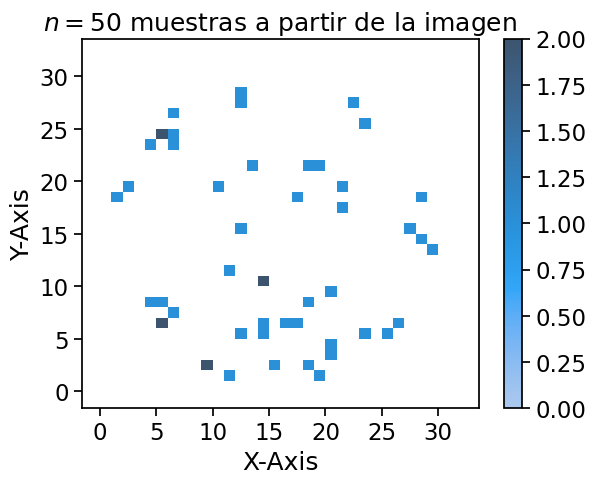

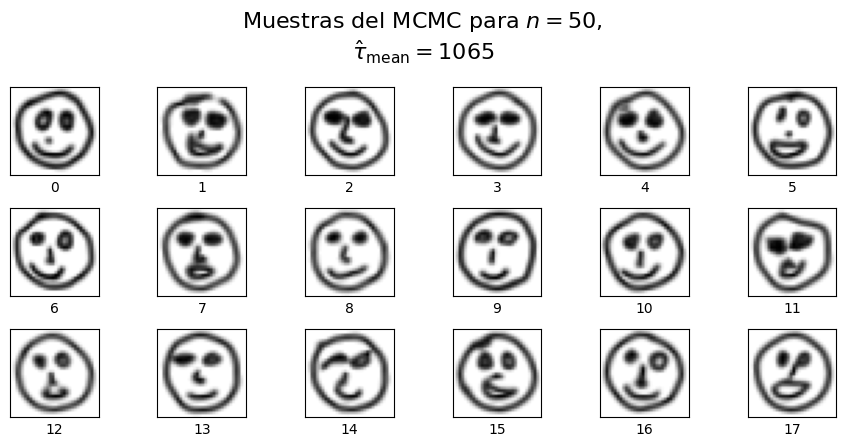

Images saved with name image-sampler-i-37
Images saved with name samples-hist-n-50
Images saved with name mcmc-n-50-NUTSPosteriorSampler
Ejecutando la cadena con n = 100


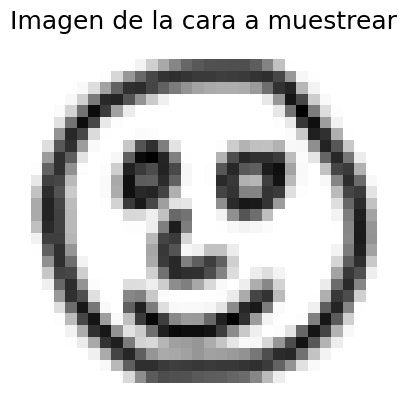

torch.Size([100])
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples       | Samples/sec
Final Adapted Step Size:  0.030952079221606255-- |   1993/152000 | 71.60       
0d:00:42:21 | 0d:00:00:00 | #################### | 152000/152000 | 59.81       
Acceptance Rate 0.80
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples       | Samples/sec
Final Adapted Step Size:  0.060468465089797974-- |   1994/152000 | 54.45       
0d:00:41:58 | 0d:00:00:00 | #################### | 152000/152000 | 60.36       
Acceptance Rate 0.63
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples       | Samples/sec
Final Adapted Step Size:  0.052813444286584854-- |   1996/152000 | 59.51       
0d:00:40:36 | 0d:00:00:00 | #################### | 152000/152000 | 62.38       
Acceptance Rate 0.68
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.

2024-07-10 09:10:27,440: WARNING [bwb.distributions.distribution_samplers:579]
> The generator_, transform_out_ and noise_sampler_ attributes will not be saved. Use fit method to fit these attributes.
/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/bwb/logging_.py:673: RuntimeWarning: The generator_, transform_out_ and noise_sampler_ attributes will not be saved. Use fit method to fit these attributes.
  log_config.raise_warning(msg, logger, warning_category, stacklevel, level,
2024-07-10 09:10:27,455: WARNING [bwb.distributions.distribution_samplers:579]
> The samples will be saved in half precision. To disable this behavior, set the attribute SAVE_HALF_PRECISION to False.
/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/bwb/logging_.py:673: RuntimeWarning: The samples will be saved in half precision. To disable this behavior, set the attribute SAVE_HALF_PRECISION to False.
  log_config.raise_warning(msg, l

2250


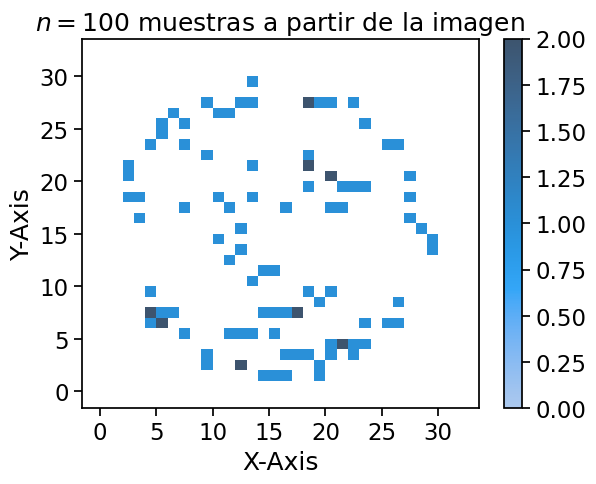

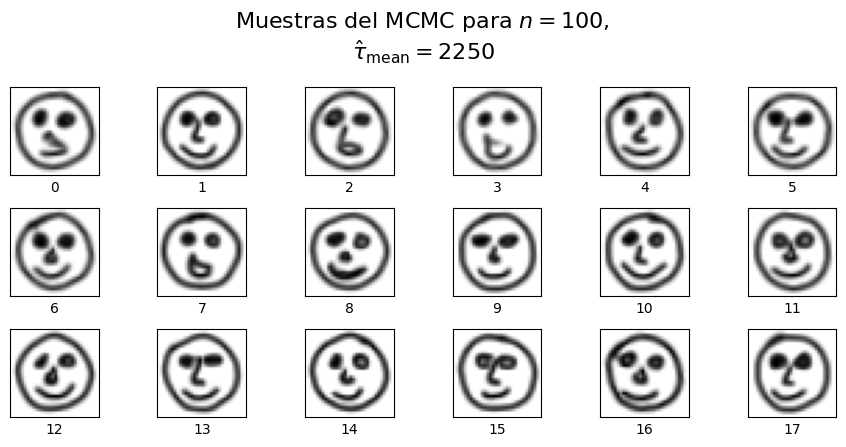

Images saved with name image-sampler-i-37
Images saved with name samples-hist-n-100
Images saved with name mcmc-n-100-NUTSPosteriorSampler


In [16]:
import pickle

data = first_face.sample((1_000,))  
    
if ic(not DATA_PATH_.exists()):
    with open(DATA_PATH_, "wb") as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)  
else:
    with open(DATA_PATH_, "rb") as f:
        data = pickle.load(f)

for n in [5, 20, 50, 100]:
    print("Ejecutando la cadena con n =", n)
    post_pi_n, (fig1, hist1, fig2) = run_mcmc_experiment(
        first_face,
        data,
        n,
        thin=None,
        nuts_params=dict(
            n_walkers=8,
            num_steps_per_sample=1,
            burn=2_000,
            desired_accept_rate=0.6,
        ),
        run_params=dict(
            n_steps=150_000,
        ),
        mcmc_plot_params=MCMC_PLOT_PARAMS,
        run_mcmc=RUN_MCMC,
        mcmc_path=NUTS_PATH,
    )

    if SAVE_FIGS:
        save_fig(fig1, f"image-sampler-i-{i}")
        save_fig(hist1, f"samples-hist-n-{n}")
        post_name = post_pi_n.__class__.__name__
        save_fig(fig2, f"mcmc-n-{n}-{post_name}")